# Fast Gaussian Process Inference Using Circulant Normal Distributions

[Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs) are powerful distributions for modeling functional data, but using them is computationally challenging except for small datasets. [Fast Fourier](https://en.wikipedia.org/wiki/Fast_Fourier_transform) methods can evaluate the likelihood efficiently if data lie on a regular grid. In this notebook, we use the `CirculantNormal` distribution to infer a latent GP with binary observations and compare with the standard `MultivariateNormal`.

**tl;dr**: Using a `CirculantNormal` gives at least a ~10x speed up in terms of effective number of samples per second even for a small GP of 64 elements. 

We consider a latent Gaussian process $z(x)$ on a regular grid $x$ which encodes the log odds of binary outcomes $y$. More formally, the model is defined as
$$\begin{aligned}
z&\sim\mathsf{MultivariateNormal}\left(0, K\right)\\
y&\sim\mathsf{Bernoulli}\left(\mathrm{expit} (z)\right),
\end{aligned}$$
where $\mathrm{expit}(z) = 1/\left(1 + \exp(-z)\right)$ denotes the [logistic sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) and $K$ is the covariance matrix between elements of the Gaussian process evaluated on the grid. We use a [squared exponential kernel](https://www.cs.toronto.edu/~duvenaud/cookbook/) $k$ such that
$$\begin{aligned}
K_{ij}&=k\left(x_i,x_j\right) + \epsilon \delta_{ij}\\
&=\sigma^2\exp\left(-\frac{d\left(x_i, x_j\right)}{2\ell^2}\right) \epsilon \delta_{ij},
\end{aligned}$$
where $\sigma$ is the marginal scale of the Gaussian process, $d\left(x_i, x_j\right)$ is the distance between $x_i$ and $x_j$, and $\ell$ is the correlation length of the kernel. We add a so-called "nugget variance" $\epsilon={10}^{-4}$ to the diagonal of the covariance matrix to ensure it is numerically positive definite.

The `CirculantNormal` distribution requires a [circulant](https://en.wikipedia.org/wiki/Circulant_matrix) covariance, i.e., one with periodic boundary conditions. Not all kernels can be represented, but the effect of boundary can be mitigated by [padding the domain](https://gptools-stan.readthedocs.io/docs/padding/padding.html).

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro matplotlib

## Generating Synthetic Data

In this example, we consider $n=64$ regularly spaced observations, correlation length $\ell=5$, and marginal scale $\sigma=2$. Depending on the `method` argument in the model below, a `CirculantNormal` or `MultivariateNormal` is used to sample $z$.

In [1]:
from time import time

from matplotlib import pyplot as plt

import jax
from jax import numpy as jnp, random
from jax.scipy.special import expit

import numpyro
from numpyro import distributions as dist


def model(x: jnp.ndarray, y: jnp.ndarray = None, *, method: str):
    """
    Latent Gaussian process model with binary outcomes.

    Args:
        x: Observation grid.
        y: Binary outcomes.
        method: Likelihood evaluation method.
    """
    n = x.size

    # Sample parameters and evaluate the kernel.
    sigma = numpyro.sample("sigma", dist.HalfCauchy())
    length_scale = numpyro.sample("length_scale", dist.InverseGamma(5, 25))
    eps = 1e-4

    if method == "circulant":
        # We can evaluate the rfft of the covariance matrix directly. This both saves us
        # some computation and is more numerically stable.
        nrfft = n // 2 + 1
        k = jnp.arange(nrfft)
        covariance_rfft = (
            sigma**2
            * length_scale
            * jnp.sqrt(2 * jnp.pi)
            * jnp.exp(-2 * (jnp.pi * k * length_scale / n) ** 2)
        ) + eps
        zdist = dist.CirculantNormal(jnp.zeros(n), covariance_rfft=covariance_rfft)
    elif method == "cholesky":
        # Evaluate the covariance matrix.
        distance = jnp.abs(x[:, None] - x)
        distance = jnp.minimum(distance, n - distance)
        covariance_matrix = sigma**2 * jnp.exp(
            -(distance**2) / (2 * length_scale**2)
        ) + eps * jnp.eye(n)
        zdist = dist.MultivariateNormal(covariance_matrix=covariance_matrix)
    z = numpyro.sample("z", zdist)

    with numpyro.plate("n", n):
        numpyro.sample("y", dist.BernoulliLogits(z), obs=y)

Having defined the model, we use a `substitute` handler to specify the parameters for synthetic data, initialize a random number key with a `seed` handler, record the model execution with a `trace` handler, and visualize the synthetic data.

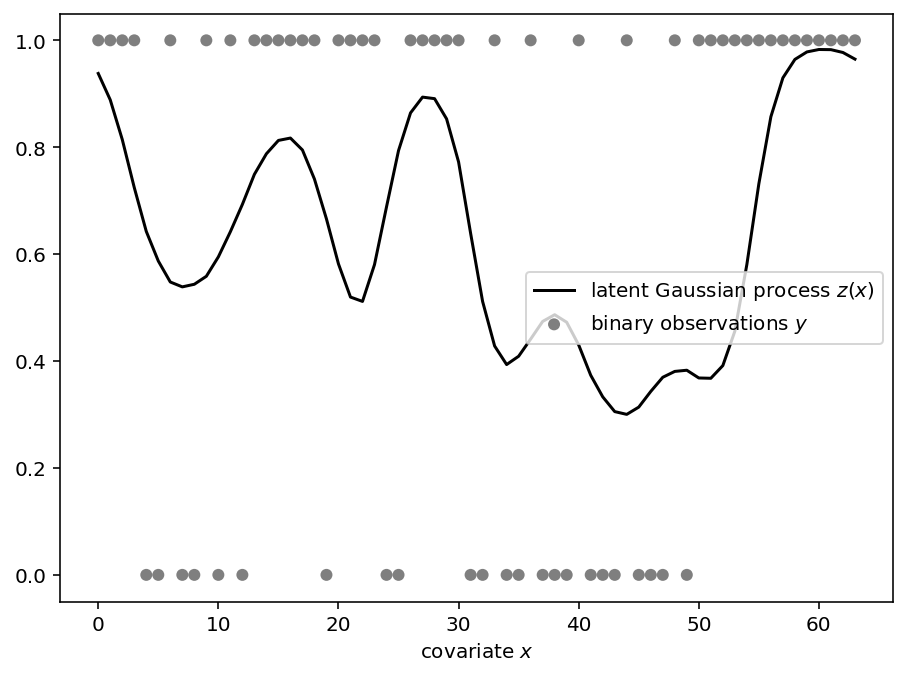

In [2]:
# Sample from the prior predictive.
with (
    numpyro.handlers.trace() as trace,
    numpyro.handlers.substitute(data={"sigma": 2, "length_scale": 5}),
    numpyro.handlers.seed(rng_seed=9),
):
    x = jnp.arange(64)
    model(x, method="circulant")
y = trace["y"]["value"]


# Plot the synthetic data.
def plot_data(x, trace, ax):
    ax.plot(
        x, expit(trace["z"]["value"]), label="latent Gaussian process $z(x)$", color="k"
    )
    ax.scatter(
        x, y, label="binary observations $y$", alpha=0.5, edgecolor="none", color="k"
    )
    ax.set_xlabel("covariate $x$")


fig, ax = plt.subplots()
plot_data(x, trace, ax=ax)
ax.legend()
fig.tight_layout()

## Sampling From the Posterior

We use a [No-U-Turn-Sampler (NUTS)](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) to draw samples from the posterior using each of the two methods. We also record the effective number of samples per second, a common metric for evaluating the performance of samplers.

In [3]:
samples_by_method = {}
n_eff_per_second_by_method = {}
for method in ["circulant", "cholesky"]:
    # Sample from the posterior using the NUTS kernel and record the duration.
    kernel = numpyro.infer.NUTS(model)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=100)
    start = time()
    mcmc.run(random.key(9), x, trace["y"]["value"], method=method)
    duration = time() - start

    # Calculate the number of effective samples per second.
    samples_by_method[method] = mcmc.get_samples()
    n_eff_per_second_by_method[method] = {
        name: site["n_eff"] / duration
        for name, site in numpyro.diagnostics.summary(
            mcmc.get_samples(group_by_chain=True)
        ).items()
    }

sample: 100%|██████████████████████████████████████████████████████████████████████| 600/600 [01:59<00:00,  5.03it/s, 1023 steps of size 4.17e-03. acc. prob=0.86]


Having drawn posterior samples, we visualize them and compare with the synthetic data we fit the model to. The plot below shows the posterior median as a line and a band from the 5th to 95th percentile.

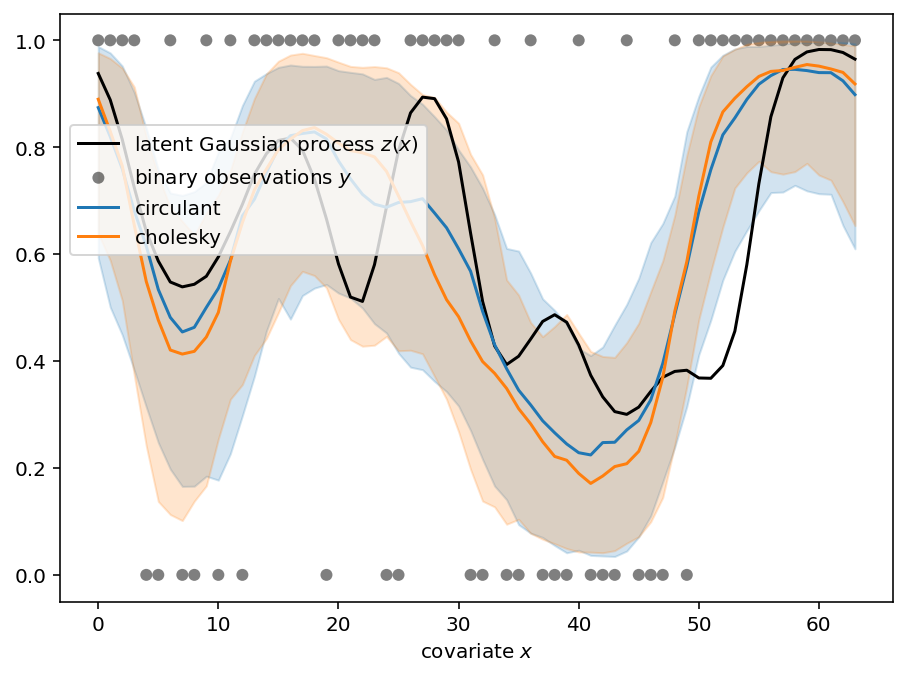

In [4]:
fig, ax = plt.subplots()
plot_data(x, trace, ax=ax)
for method, samples in samples_by_method.items():
    lower, median, upper = jnp.percentile(
        expit(samples["z"]), jnp.array([5, 50.0, 95]), axis=0
    )
    (line,) = ax.plot(x, median, label=method)
    ax.fill_between(x, lower, upper, color=line.get_color(), alpha=0.2)

ax.legend(loc="center left", bbox_to_anchor=(0, 0.7))
fig.tight_layout()

So how well did we do? The runtime is about 40x faster using the `CirculantNormal`. The number of effective samples per second varies between parameters, but we observe a 15x to 140x improvement depending on the parameter. Experiments were run on a 2020 Macbook Pro with M1 chip.

In [5]:
# Report the speed up due to using the `CirculantNormal`.
speedups = jax.tree.map(jnp.divide, *n_eff_per_second_by_method.values())
for site, speedup in speedups.items():
    print(
        f"speedup for `{site}`: min = {speedup.min():.2f}, "
        f"mean = {speedup.mean():.2f}, max = {speedup.max():.2f}"
    )

speedup for `length_scale`: min = 10.97, mean = 10.97, max = 10.97
speedup for `sigma`: min = 63.37, mean = 63.37, max = 63.37
speedup for `z`: min = 16.27, mean = 51.68, max = 140.84
